[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Guetguet6/PenguinVsTurtle/blob/main/notebook.ipynb)

In [1]:
!rm -rf PenguinVsTurtle
!git clone -b feat/Gaetan --single-branch https://github.com/Guetguet6/PenguinVsTurtle.git

Cloning into 'PenguinVsTurtle'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 5), reused 19 (delta 5), pack-reused 0
Receiving objects: 100% (22/22), 175.20 KiB | 21.90 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
!rm -rf data archive.zip
!wget "https://drive.usercontent.google.com/u/0/uc?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download" -O archive.zip
!unzip -q archive.zip -d data
!mv data/train_annotations data/train_annotations.json
!mv data/valid_annotations data/valid_annotations.json

--2024-03-10 19:36:16--  https://drive.usercontent.google.com/u/0/uc?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.68.132, 2404:6800:4003:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.68.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download [following]
--2024-03-10 19:36:16--  https://drive.usercontent.google.com/uc?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download [following]
--2024-03-10 19:36:17--  https://drive.usercontent.google.com/download?id=1N5HskbYc1bzl-qxF2cpyT-kBq-yLxIlU&export=download
Reusing exist

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import pandas as pd
from pandas import DataFrame

from skimage import io
import os

import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
class PenguinVsTurtleDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: str, json_file: str, split: str = 'train', transform: torchvision.transforms = None):
        self.root_dir: str = os.path.join(root_dir, split, split)
        self.annotations: DataFrame = pd.read_json(os.path.join(root_dir, json_file))
        self.transform: torchvision.transforms = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_id = self.annotations.iloc[index]["image_id"]
        img_path = os.path.join(self.root_dir, f'image_id_{image_id:03d}.jpg')
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index]['category_id']))

        if self.transform:
            image = self.transform(image)

        return [image, y_label]

In [8]:
resize_imgs = 300
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5), transforms.Resize((resize_imgs,resize_imgs))])

In [9]:
try:
    import google.colab
    from PenguinVsTurtle.TP5_MHA import MultiHeadAttention
except ModuleNotFoundError:
    from TP5_MHA import MultiHeadAttention

directory = 'data'

In [10]:
train_dataset = PenguinVsTurtleDataset(root_dir=directory, split="train", json_file='train_annotations.json', transform=transform)
valid_dataset = PenguinVsTurtleDataset(root_dir=directory, split="valid", json_file='valid_annotations.json', transform=transform)

print('Number of training examples: ', len(train_dataset))
print('Number of validation examples: ', len(valid_dataset))

Number of training examples:  500
Number of validation examples:  72


In [11]:
batch_size=32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
batch_idx, data = next(enumerate(train_dataloader))
print(len(data))
print('Images:', data[0].shape)
b, c, h, w = data[0].shape
print('Batch(s):', b)               # 32 images traitées à la fois
print('Channel(s):', c)             # 3 canaux de couleur, image RGB
print('Height:', h)                 # 320 pixels de hauteur
print('Width:', w)                  # 320 pixels de largeur
print('Labels:', data[1].shape)     # 32 labels

2
Images: torch.Size([32, 3, 300, 300])
Batch(s): 32
Channel(s): 3
Height: 300
Width: 300
Labels: torch.Size([32])


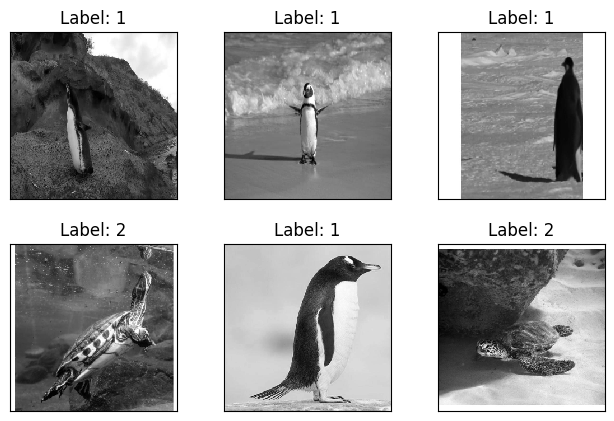

In [13]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(data[0][i][0], cmap='gray', interpolation='none')
    plt.title(f'Label: {data[1][i]}')
    plt.xticks([])
    plt.yticks([])

In [14]:
class VisionEncoder(torch.nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size, dropout):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Première couche : Linear + LayerNorm
        self.norm1 = torch.nn.LayerNorm(embed_size)
        self.mha = MultiHeadAttention(embed_size, num_heads, dropout)
        self.add_norm = torch.nn.Sequential(
            torch.nn.Linear(embed_size, hidden_size),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, embed_size),
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        # Première couche : Normalisation + Multi-Head Attention + Résiduel
        norm1_output = self.norm1(x)
        mha_output = self.mha(norm1_output, norm1_output, norm1_output)
        add_norm1_output = x + mha_output

        # Deuxième couche : Linear + GELU + Dropout + Linear + Dropout + Résiduel
        mlp_output = self.add_norm(add_norm1_output)
        add_norm2_output = add_norm1_output + mlp_output

        return add_norm2_output

In [15]:
class ViT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, nb_heads, classes, nb_layers, hidden_size, dropout):
        super(ViT, self).__init__()

        # Paramètres
        self.image_size = image_size
        self.channel_size = channel_size
        self.pixels = image_size ** 2 * channel_size

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.nb_patches = (image_size // patch_size) ** 2
        self.pixels_per_patch = channel_size * (patch_size ** 2)
        self.nb_heads = nb_heads
        self.classes = classes
        self.nb_layers = nb_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = torch.nn.Dropout(p=dropout)

        # Projection linéaire
        self.embeddings = nn.Linear(self.pixels_per_patch, self.embed_size)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_size))

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, self.nb_patches + 1, embed_size))

        # Layers d'encodage
        self.encoders = nn.ModuleList([
            VisionEncoder(embed_size, nb_heads, hidden_size, dropout)
            for _ in range(nb_layers)
        ])

        # Classification
        self.norm = nn.LayerNorm(embed_size)
        self.classifier = nn.Linear(embed_size, classes)

    def forward(self, img_torch):
        b, c, h, w = img_torch.size()

        img_torch_reshape = img_torch.reshape(b, int((h / self.patch_size) * (w / self.patch_size)), c * self.patch_size * self.patch_size)
        fwd_embeddings = self.embeddings(img_torch_reshape)

        b, n, e = fwd_embeddings.size()
        class_tokens = self.class_token.expand(b, 1, e)

        concat = torch.cat((fwd_embeddings, class_tokens), dim=1)

        fwd_concat = concat + self.positional_encoding

        # Layout
        fwd_dropout = self.dropout_layer(fwd_concat)

        # Layers d'encodage
        for encoder in self.encoders:
            fwd_dropout = encoder(fwd_dropout)
        fwd_encodeurs = fwd_dropout

        # Classification
        cls_token = fwd_encodeurs[:, -1, :]
        cls_token = self.norm(cls_token)
        classification = self.classifier(cls_token)
        fwd_softmac = torch.nn.functional.log_softmax(classification, dim=1)
        return fwd_softmac

model = ViT(image_size=resize_imgs, channel_size=3, patch_size=10, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2).to(device)

In [16]:
loss_fct = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [17]:
# Liste pour conserver les valeurs de loss (rappel : on souhaite minimiser la valeur de loss)
losses = []

# Liste pour conserver les précisions du modèle (en %)
accuracies = []

# Ces listes permettront d'afficher les courbes de loss et de précision après l'entrainement

# 1 epoch correspond à un passage complet sur l'ensemble des données (les 60000 images !)
# Le modèle va donc voir chaque image 10 fois
nb_epochs = 15

# Boucle permettant de faire nb_epochs passages sur l'ensemble des données
for epoch in range(nb_epochs):

  # Passage du modèle en mode entrainement (certains paramètres agissent différemment selon si il s'agit de la phase d'entrainement ou d'évaluation)
  model.train()

  # Récupération de la loss sur l'epoch
  epoch_loss = 0

  # Liste pour conserver l'ensemble des prédictions faites durant l'epoch actuelle
  y_pred = []

  # Liste pour conserver l'ensemble des valeurs à prédire durant l'epoch actuelle
  y_true = []

  # Boucle permettant de parcourir l'ensemble des données du DataLoader (les 60000 images !)
  # Chaque itération contient 32 images et labels comme défini lors de la création du DataLoader
  for batch_idx, (imgs, labels) in enumerate(train_dataloader):
    # Envoi des données sur le processeur choisi (CPU ou GPU)
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Passage du batch d'images dans le modèle ViT conçu
    predictions = model(imgs)

    # Calcul de la loss sur le batch
    loss = loss_fct(predictions, labels)

    # Nettoyage des anciens paramètres de mise à jour calculés
    optimizer.zero_grad()

    # Calcul des paramètres du modèle à mettre à jour (rétropropagation du gradient)
    loss.backward()

    # Mise à jour des paramètres du modèle
    optimizer.step()

    # Mise à jour de la loss sur l'epoch
    epoch_loss += loss.item()

    # La variable contient pour chaque image du batch 10 valeurs
    # Chaque valeur correspond à une probabilité pour chacun des chiffres entre 0 et 9
    # L'indice de la probabilité la plus forte correspond au chiffre prédit par le réseau !

    # On ajoute les prédictions et les valeurs à prédire dans les listes correspondantes
    y_pred.extend(torch.argmax(predictions, dim=1).detach().cpu().tolist())
    y_true.extend(labels.detach().tolist())

  # Ajout de la loss de l'epoch à la liste de l'ensemble des loss
  losses.append(epoch_loss)

  # Vérification et calcul de la précision du modèle en comparant pour chaque image son label avec la valeur prédite
  nb_imgs = len(y_pred)
  total_correct = 0
  for i in range(nb_imgs):
    if y_pred[i] == y_true[i]:
      total_correct += 1

  accuracy = total_correct * 100 / nb_imgs

  # Ajout de la précision à la liste des précisions
  accuracies.append(accuracy)

  # Affichage des résultats pour l'epoch en cours (loss et précision)
  print("----------")
  print("Epoch:", epoch)
  print("Loss:", epoch_loss)
  print(f"Accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

----------
Epoch: 0
Loss: 22.656687259674072
Accuracy: 40.4 % (202 / 500)
----------
Epoch: 1
Loss: 12.495958507061005
Accuracy: 51.8 % (259 / 500)
----------
Epoch: 2
Loss: 11.111355364322662
Accuracy: 57.2 % (286 / 500)
----------
Epoch: 3
Loss: 10.295167863368988
Accuracy: 65.2 % (326 / 500)
----------
Epoch: 4
Loss: 9.665657639503479
Accuracy: 70.2 % (351 / 500)
----------
Epoch: 5
Loss: 9.323248267173767
Accuracy: 69.0 % (345 / 500)
----------
Epoch: 6
Loss: 9.22074693441391
Accuracy: 72.0 % (360 / 500)
----------
Epoch: 7
Loss: 8.301565498113632
Accuracy: 75.4 % (377 / 500)
----------
Epoch: 8
Loss: 8.188400030136108
Accuracy: 75.2 % (376 / 500)
----------
Epoch: 9
Loss: 8.16213458776474
Accuracy: 76.8 % (384 / 500)
----------
Epoch: 10
Loss: 8.369170010089874
Accuracy: 73.6 % (368 / 500)
----------
Epoch: 11
Loss: 8.018859326839447
Accuracy: 74.6 % (373 / 500)
----------
Epoch: 12
Loss: 8.0443816781044
Accuracy: 74.8 % (374 / 500)
----------
Epoch: 13
Loss: 7.7341044545173645
Ac

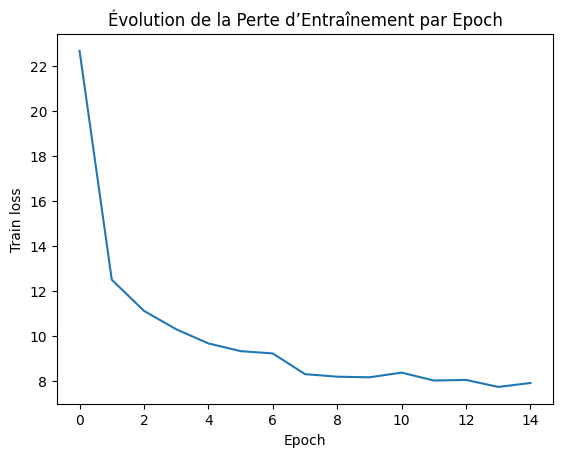

In [18]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Évolution de la Perte d’Entraînement par Epoch")
plt.show()

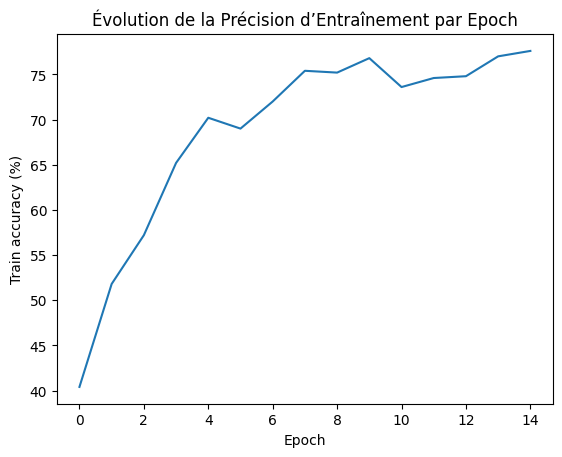

In [19]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Train accuracy (%)")
plt.title("Évolution de la Précision d’Entraînement par Epoch")
plt.show()

In [20]:
with torch.no_grad():
  model.eval()

  y_test_pred = []
  y_test_true = []

  for batch_idx, (imgs, labels) in enumerate(valid_dataloader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    predictions = model(imgs)

    y_test_pred.extend(predictions.detach().argmax(dim=1).tolist())
    y_test_true.extend(labels.detach().tolist())

nb_imgs = len(y_test_pred)
total_correct = 0
for i in range(nb_imgs):
  if y_test_pred[i] == y_test_true[i]:
    total_correct += 1

accuracy = total_correct * 100 / nb_imgs

print(f"Evaluation accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

Evaluation accuracy: 55.55555555555556 % (40 / 72)


In [ ]:
torch.save(model.state_dict(), 'model_trained.pth')